## Sentiment Analysis in Python

Sentiment analysis will be performed using different techniques:

1. VADER (Valence Aware Dictionary and sEntiment Reasoner) - Bag of words approach
2. Roberta Pretrained Model from Huggingface
3. Huggingface Pipeline

## Step 0: Read in Data and NLTK Basics

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('ggplot')

import nltk # natural language took kit

In [2]:
# Reading the csv file
df = pd.read_csv('Reviews.csv')

In [3]:
df.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [4]:
# Review by the reviewer for the product (run sentiment analysis for this row)
df['Text'].values[0]

'I have bought several of the Vitality canned dog food products and have found them all to be of good quality. The product looks more like a stew than a processed meat and it smells better. My Labrador is finicky and she appreciates this product better than  most.'

In [5]:
df.shape

(568454, 10)

In [6]:
# scaling down the dataset for simplicity
df = df.head(500)

## Step 1: Quick EDA

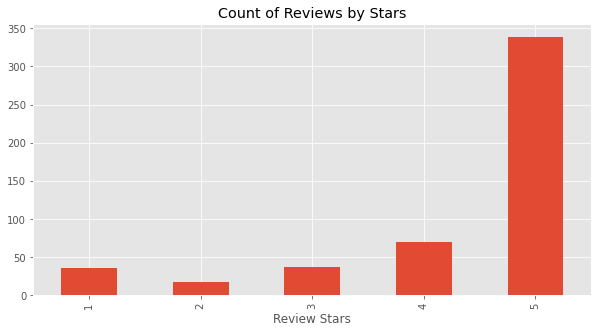

In [7]:
axis = df['Score'].value_counts().sort_index() \
    .plot(kind='bar', title='Count of Reviews by Stars', figsize=(10,5))
axis.set_xlabel('Review Stars')
plt.show()

## Step 2: Basic NLTK

In [8]:
example = df['Text'][50]
print(example)

This oatmeal is not good. Its mushy, soft, I don't like it. Quaker Oats is the way to go.


In [9]:
# nltk.download('punkt')
# nltk.download('all')
tokens = nltk.word_tokenize(example)    # tokenize the text
tokens[:10]

['This', 'oatmeal', 'is', 'not', 'good', '.', 'Its', 'mushy', ',', 'soft']

In [10]:
tagged = nltk.pos_tag(tokens)    # pos_tag - part of speech tag (https://www.guru99.com/pos-tagging-chunking-nltk.html)
tagged[:10]

[('This', 'DT'),
 ('oatmeal', 'NN'),
 ('is', 'VBZ'),
 ('not', 'RB'),
 ('good', 'JJ'),
 ('.', '.'),
 ('Its', 'PRP$'),
 ('mushy', 'NN'),
 (',', ','),
 ('soft', 'JJ')]

In [11]:
entities = nltk.chunk.ne_chunk(tagged)   # groups them into chunks of texts
entities.pprint()

(S
  This/DT
  oatmeal/NN
  is/VBZ
  not/RB
  good/JJ
  ./.
  Its/PRP$
  mushy/NN
  ,/,
  soft/JJ
  ,/,
  I/PRP
  do/VBP
  n't/RB
  like/VB
  it/PRP
  ./.
  (ORGANIZATION Quaker/NNP Oats/NNPS)
  is/VBZ
  the/DT
  way/NN
  to/TO
  go/VB
  ./.)


## Step 3: VADER Sentiment Scoring

We will use NLTK's SentimentIntensityAnalyser to get the neg/neu/pos scores of the text.

This uses a "bag of words" approach:
1. Stop words are removed
2. Each word is scored and combined to a total score

*Important: Does *NOT* account for relationships between words

In [12]:
from nltk.sentiment import SentimentIntensityAnalyzer
from tqdm.notebook import tqdm

sia = SentimentIntensityAnalyzer()

In [13]:
sia.polarity_scores('I am so happy!')   # Example (compound is between -1 to 1)

{'neg': 0.0, 'neu': 0.318, 'pos': 0.682, 'compound': 0.6468}

In [14]:
sia.polarity_scores('This is the worst ever!')   # Example (compound is between -1 to 1)

{'neg': 0.523, 'neu': 0.477, 'pos': 0.0, 'compound': -0.6588}

In [15]:
print(example)
sia.polarity_scores(example)

This oatmeal is not good. Its mushy, soft, I don't like it. Quaker Oats is the way to go.


{'neg': 0.22, 'neu': 0.78, 'pos': 0.0, 'compound': -0.5448}

In [16]:
# Run the polarity score on the df
res = {}
for i, row in tqdm(df.iterrows(), total=len(df)):
    text = row['Text']
    myid = row['Id']
    res[myid] = sia.polarity_scores(text)

  0%|          | 0/500 [00:00<?, ?it/s]

In [17]:
pd.DataFrame(res)

,1,2,3,4,5,6,7,8,9,10,...,491,492,493,494,495,496,497,498,499,500
neg,0.0000,0.1380,0.0910,0.0,0.0000,0.029,0.0340,0.0000,0.0000,0.0000,...,0.0550,0.0000,0.0560,0.1000,0.0000,0.0000,0.0590,0.0250,0.041,0.0000
neu,0.6950,0.8620,0.7540,1.0,0.5520,0.809,0.6930,0.5200,0.8510,0.7050,...,0.7040,0.7170,0.8550,0.6450,0.7880,0.5540,0.7990,0.7620,0.904,0.6780
pos,0.3050,0.0000,0.1550,0.0,0.4480,0.163,0.2730,0.4800,0.1490,0.2950,...,0.2410,0.2830,0.0890,0.2540,0.2120,0.4460,0.1420,0.2120,0.055,0.3220
compound,0.9441,-0.5664,0.8265,0.0,0.9468,0.883,0.9346,0.9487,0.6369,0.8313,...,0.9287,0.9367,0.5976,0.6486,0.9743,0.9725,0.7833,0.9848,0.128,0.9811


In [18]:
# transpose
pd.DataFrame(res).T

,neg,neu,pos,compound
1,0.000,0.695,0.305,0.9441
2,0.138,0.862,0.000,-0.5664
3,0.091,0.754,0.155,0.8265
4,0.000,1.000,0.000,0.0000
5,0.000,0.552,0.448,0.9468
...,...,...,...,...
496,0.000,0.554,0.446,0.9725
497,0.059,0.799,0.142,0.7833
498,0.025,0.762,0.212,0.9848
499,0.041,0.904,0.055,0.1280


In [19]:
vaders = pd.DataFrame(res).T
vaders = vaders.reset_index().rename(columns={'index': 'Id'})
vaders = vaders.merge(df, how='left')

In [20]:
vaders.head()

,Id,neg,neu,pos,compound,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,0.000,0.695,0.305,0.9441,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,0.138,0.862,0.000,-0.5664,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,0.091,0.754,0.155,0.8265,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,0.000,1.000,0.000,0.0000,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,0.000,0.552,0.448,0.9468,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


### Plot VADER Results

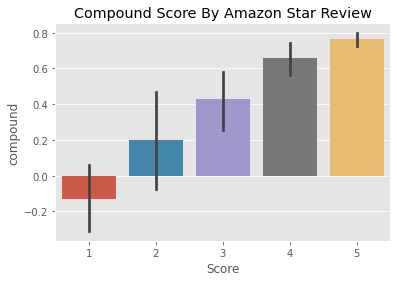

In [21]:
ax = sns.barplot(data=vaders, x='Score', y='compound')
ax.set_title('Compound Score By Amazon Star Review')
plt.show()

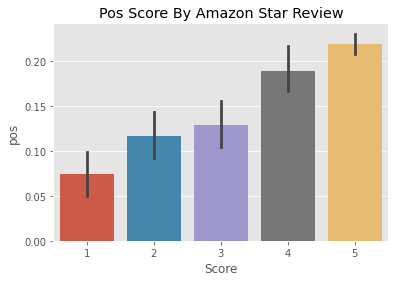

In [22]:
ax = sns.barplot(data=vaders, x='Score', y='pos')
ax.set_title('Pos Score By Amazon Star Review')
plt.show()

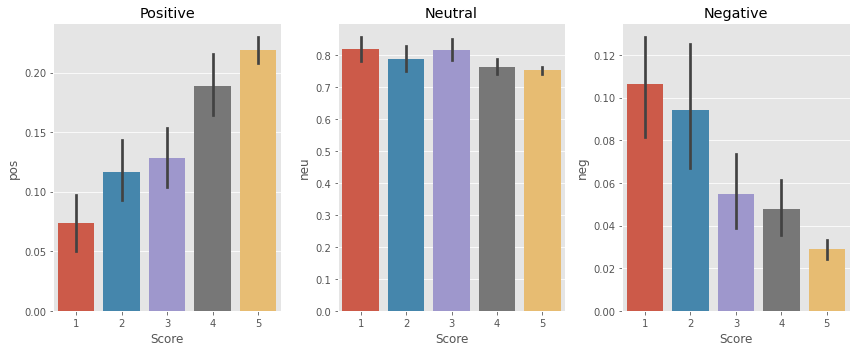

In [23]:
fig, axs = plt.subplots(1, 3, figsize=(12,5))
sns.barplot(data=vaders, x='Score', y='pos', ax=axs[0])
sns.barplot(data=vaders, x='Score', y='neu', ax=axs[1])
sns.barplot(data=vaders, x='Score', y='neg', ax=axs[2])
axs[0].set_title('Positive')
axs[1].set_title('Neutral')
axs[2].set_title('Negative')
plt.tight_layout()
plt.show()

## Step 4: Roberta Pretrained Model

1. Use a model trained on large corpus of data
2. Transformer model accounts for the words but also the contect related to other words.

In [24]:
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification
from scipy.special import softmax
import torch

# x = torch.rand(5, 3)
# print(x)

In [25]:
MODEL = f'cardiffnlp/twitter-roberta-base-sentiment'
tokenizer = AutoTokenizer.from_pretrained(MODEL)
model = AutoModelForSequenceClassification.from_pretrained(MODEL)

pytorch_model.bin:   0%|          | 0.00/499M [00:00<?, ?B/s]

c:\Users\sanka\AppData\Local\Programs\Python\Python39\lib\site-packages\huggingface_hub\file_download.py:147: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\sanka\.cache\huggingface\hub. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to see activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


In [27]:
# VADER Results
print(example)
sia.polarity_scores(example)

This oatmeal is not good. Its mushy, soft, I don't like it. Quaker Oats is the way to go.


{'neg': 0.22, 'neu': 0.78, 'pos': 0.0, 'compound': -0.5448}

In [35]:
# Run for RoBERTa Model
encoded_texts = tokenizer(example, return_tensors='pt')
output = model(**encoded_texts)
scores = output[0][0].detach().numpy()
scores = softmax(scores)
scores

array([0.97635514, 0.02068747, 0.00295737], dtype=float32)

In [37]:
scores_dict = {
    'roberta_neg': scores[0],
    'roberta_neu': scores[1],
    'roberta_pos': scores[2]
}
print(scores_dict)

{'roberta_neg': 0.97635514, 'roberta_neu': 0.02068747, 'roberta_pos': 0.0029573706}


In [38]:
# Run RoBERTa Model on df
def polarity_scores_roberta(example):
    encoded_texts = tokenizer(example, return_tensors='pt')
    output = model(**encoded_texts)
    scores = output[0][0].detach().numpy()
    scores = softmax(scores)
    scores_dict = {
        'roberta_neg': scores[0],
        'roberta_neu': scores[1],
        'roberta_pos': scores[2]
    }
    return scores_dict

In [43]:
res = {}
for i, row in tqdm(df.iterrows(), total=len(df)):
    try:
        text = row['Text']
        myid = row['Id']
        vader_result = sia.polarity_scores(text)
        vader_result_rename = {}
        for key, value in vader_result.items():
            vader_result_rename[f'vader_{key}'] = value
        roberta_result = polarity_scores_roberta(text)
        both = {**vader_result_rename, **roberta_result}
        res[myid] = both
    except RuntimeError:
        print(f'Broke for id {myid}')

  0%|          | 0/500 [00:00<?, ?it/s]

Broke for id 83
Broke for id 187


In [45]:
results_df = pd.DataFrame(res).T
results_df = results_df.reset_index().rename(columns={'index': 'Id'})
results_df = results_df.merge(df, how='left')

In [46]:
results_df.head()

,Id,vader_neg,vader_neu,vader_pos,vader_compound,roberta_neg,roberta_neu,roberta_pos,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,0.000,0.695,0.305,0.9441,0.009624,0.049980,0.940395,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,0.138,0.862,0.000,-0.5664,0.508986,0.452414,0.038600,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,0.091,0.754,0.155,0.8265,0.003229,0.098067,0.898704,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,0.000,1.000,0.000,0.0000,0.002295,0.090219,0.907486,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,0.000,0.552,0.448,0.9468,0.001635,0.010302,0.988063,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


### Compare Scores between models

In [47]:
results_df.columns

Index(['Id', 'vader_neg', 'vader_neu', 'vader_pos', 'vader_compound',
       'roberta_neg', 'roberta_neu', 'roberta_pos', 'ProductId', 'UserId',
       'ProfileName', 'HelpfulnessNumerator', 'HelpfulnessDenominator',
       'Score', 'Time', 'Summary', 'Text'],
      dtype='object')

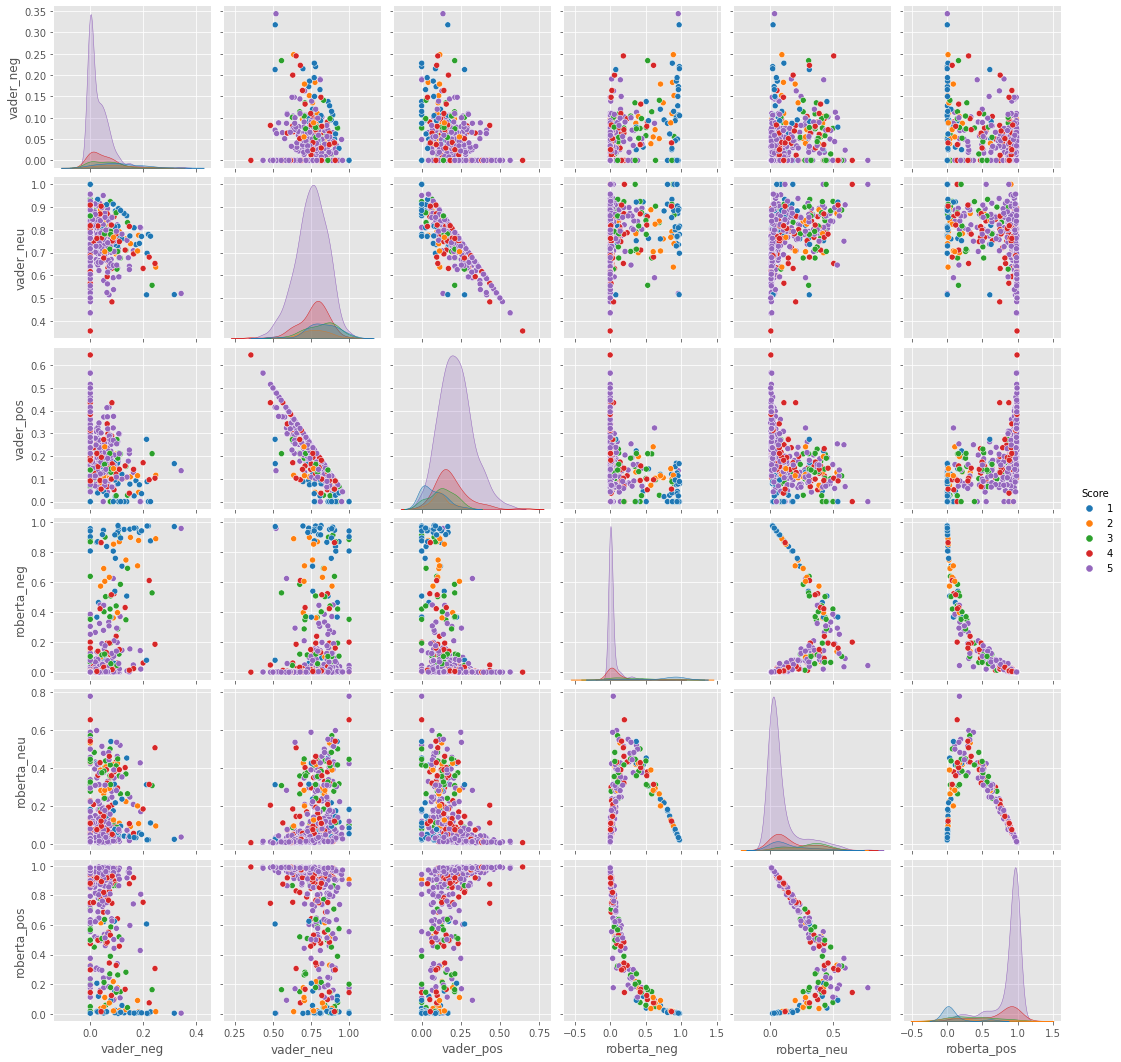

In [49]:
sns.pairplot(data=results_df, vars=['vader_neg', 'vader_neu', 'vader_pos',
       'roberta_neg', 'roberta_neu', 'roberta_pos'],
       hue='Score',
       palette='tab10')
plt.show()

## Step 5: Review Examples:

1. Positive 1-Star and Negative 5-Star Reviews

Lets look at some examples where the model scoring and review differ the most

In [50]:
results_df.query('Score == 1').sort_values('roberta_pos', ascending=False)['Text'].values[0]

'I felt energized within five minutes, but it lasted for about 45 minutes. I paid $3.99 for this drink. I could have just drunk a cup of coffee and saved my money.'

In [51]:
results_df.query('Score == 1').sort_values('vader_pos', ascending=False)['Text'].values[0]

'So we cancelled the order.  It was cancelled without any problem.  That is a positive note...'

In [53]:
# negative sentiment 5-Star review
results_df.query('Score == 5').sort_values('roberta_neg', ascending=False)['Text'].values[0]

'this was sooooo deliscious but too bad i ate em too fast and gained 2 pds! my fault'

In [54]:
results_df.query('Score == 5').sort_values('vader_neg', ascending=False)['Text'].values[0]

'this was sooooo deliscious but too bad i ate em too fast and gained 2 pds! my fault'

## Extra: Huggingface Transformers Pipeline

Quick and easy way to run sentiment predictions

In [55]:
from transformers import pipeline

sent_pipeline = pipeline('sentiment-analysis')

No model was supplied, defaulted to distilbert-base-uncased-finetuned-sst-2-english and revision af0f99b (https://huggingface.co/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.


config.json:   0%|          | 0.00/629 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

In [56]:
sent_pipeline('I love sentiment analysis')

[{'label': 'POSITIVE', 'score': 0.999736487865448}]

In [57]:
sent_pipeline('Ouch')

[{'label': 'NEGATIVE', 'score': 0.9993736147880554}]

# The End